# Entrenamiento desde cero para segmentación de Imágenes Médicas



Se utiliza el dataset de BTCV que se puede descargar de https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

Este dataset contiene 13 órganos abdominales incluyendo 1. Bazo 2. Riñón derecho 3. Riñón izquierdo 4. Vesícula biliar 5. Esófago 6. Hígado 7. Estómago 8. Aorta 9. VCI 10. Venas portal y esplénica 11. Páncreas 12 Glándula adrenal derecha 13 Glándula adrenal izquierda.

Modalidad: CT (Tomografía Computarizada)
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

Este cuaderno puede ser ejecutado en Google Colab, aunque no va a funcionar en la versión gratuita de Google Colab. Se necesita al menos Google Colab PRO con el entorno de ejecución de GPU Estandar y Alta capacidad RAM. Se recomienda el entorno GPU Premium.

Si se ejecuta en local, los requisitos minimos son GPU de 16GB y Memoria RAM de 24GB.

[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franguerrero/TFM_SegmentacionImagenesMedicas/blob/main/cuadernos_jupyter/TFM_EntrenamientoDesdeCero_BTCV.ipynb)

## Setup del entorno

Verificamos si está conectado con la GPU y mostramos la información de la GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('fallo') >= 0:
  print('No conectado a GPU')
else:
  print(gpu_info)

Fri Feb  3 22:06:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Instalamos las librerias de MONAI en su ultima versión estable que en el momento de la realización de este cuaderno es la 1.1.0

!pip install -q "monai[nibabel, tqdm, einops]"==1.1.0
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.3 MB/s eta 0:00:00


In [3]:
# Importamos aquellas librerias que nos van a hacer falta tanto de MONAI como otras como de numpy o matplotlib
# Finalizamos viendo las versiones instaladas de cada una de ellas

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup directorios de trabajo

Establecemos la conexión con la cuenta de Google Drive y le especificamos la carpeta donde vamos a almacenar los resultados del modelo que obtengamos

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Ruta de Google Drive donde vamos a almacenar los resultados
os.environ['MONAI_DATA_DIRECTORY'] = '/content/gdrive/MyDrive/TFM_SegmentacionImagenesMedicas/Resultados/'

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/gdrive/MyDrive/TFM_SegmentacionImagenesMedicas/Resultados/


## Setup de las transformaciones para entrenamiento (training) y validacion

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

 ## Descarga del dataset y almacenamiento en Google Drive
El dataset ha sido descargado de  https://www.synapse.org/#!Synapse:syn3193805/wiki/217752 y se ha subido a la aplicacion de google drive. 

En concreto a la ruta \MyDrive\TFM_SegmentacionImagenesMedicas\Datasets\BTCV 

Es importante señalar que las imágenes del dataset de BTCV van a la carpeta \textbackslash imagesTr y las etiquetas van a la carpeta \textbackslash labelsTr.

Además también se encuentra el fichero dataset\_0.json que contiene la descripción de las imágenes y sus correspondientes etiquetas de ground truth que van a ser usadas para el entrenamiento y las que van a ser usadas para validación. En nuestro caso se han usado 24 imágenes (y correspondientes etiquetas) para entrenamiento y 6 para validación. Las de validación se corresponden con la numeración desde la 35 a la 40 ambas incluidas.

In [8]:
# Establecemos la ruta donde se encuentran las imagenes y etiquetas de BTCV descargadas
data_dir = "/content/gdrive/MyDrive/TFM_SegmentacionImagenesMedicas/Datasets/BTCV/"
split_JSON = "dataset_0.json"

datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")

# Cacheamos los datos de entrenamiento y validación
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


## Visualizamos imagen y etiquetas y comprobamos la forma de los datos

forma de la imagen: torch.Size([1, 314, 214, 234]), forma de la etiqueta: torch.Size([1, 314, 214, 234])
Nombre de la Imagen: img0035.nii.gz 


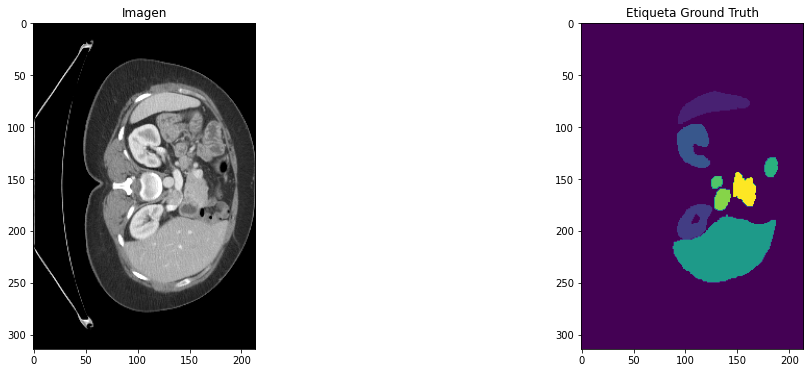

In [9]:
# Definimos un mapeo de los datos de validación
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}

# Seleccionamos uno cualquiera, por ejemplo el que esta en el lugar 0 del map
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"forma de la imagen: {img_shape}, forma de la etiqueta: {label_shape}")
print(f"Nombre de la Imagen: {img_name} ")
plt.figure("Imagen", (18, 6))
plt.subplot(1, 2, 1)
plt.title("Imagen")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Etiqueta Ground Truth")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Definimos el modelo, la funcion de pérdida y el optimizador


In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definimos el modelo de arquitectura de segmentacion, en este caso una UNETR
model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

# Definimos la funcion de perdida
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True

#Definimos el optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Ejecutamos un proceso de entrenamiento de red neuronal típico de PyTorch una vez que previamente hemos definido modelo, funcion de pérdida y optimizador

In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validar (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (Perdida loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validar (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            # Guardamos el modelo que tiene mejor metrica DICE
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "mejor_modelo_metrica.pth")
                )
                print(
                    "Se ha salvado el modelo ! Mejor Avg. Dice: {} Actual Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "No se ha salvado el modelo ! Mejor Avg. Dice: {} Actual Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

# Numero máximo de iteraciones. Para buenos resultados se recomienda 25000
max_iterations = 2000

# Cada cuantos pasos evaluamos
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)

# Parametrizamos la métrica DICE a usar
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

# Mandamos el modelo a entrenar
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

# Cargamos el mejor modelo conseguido
model.load_state_dict(torch.load(os.path.join(root_dir, "mejor_modelo_metrica.pth")))

Training (22 / 2000 Steps) (Perdida loss=3.46918): 100%|██████████| 23/23 [00:17<00:00,  1.30it/s]
Training (45 / 2000 Steps) (Perdida loss=3.23610): 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
Training (68 / 2000 Steps) (Perdida loss=3.12252): 100%|██████████| 23/23 [00:07<00:00,  3.05it/s]
Training (91 / 2000 Steps) (Perdida loss=3.17014): 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
Training (114 / 2000 Steps) (Perdida loss=2.94225): 100%|██████████| 23/23 [00:07<00:00,  3.00it/s]
Training (137 / 2000 Steps) (Perdida loss=2.86278): 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
Training (160 / 2000 Steps) (Perdida loss=2.84281): 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
Training (183 / 2000 Steps) (Perdida loss=2.67956): 100%|██████████| 23/23 [00:07<00:00,  3.10it/s]
Training (206 / 2000 Steps) (Perdida loss=2.74652): 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
Training (229 / 2000 Steps) (Perdida loss=2.63646): 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
Trai

Se ha salvado el modelo ! Mejor Avg. Dice: 0.09352534264326096 Actual Avg. Dice: 0.09352534264326096


Training (505 / 2000 Steps) (Perdida loss=2.26599): 100%|██████████| 23/23 [00:13<00:00,  1.72it/s]
Training (528 / 2000 Steps) (Perdida loss=2.16582): 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
Training (551 / 2000 Steps) (Perdida loss=2.07153): 100%|██████████| 23/23 [00:07<00:00,  2.89it/s]
Training (574 / 2000 Steps) (Perdida loss=2.17690): 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]
Training (597 / 2000 Steps) (Perdida loss=2.17091): 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
Training (620 / 2000 Steps) (Perdida loss=2.16600): 100%|██████████| 23/23 [00:07<00:00,  3.02it/s]
Training (643 / 2000 Steps) (Perdida loss=1.99058): 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
Training (666 / 2000 Steps) (Perdida loss=2.05391): 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]
Training (689 / 2000 Steps) (Perdida loss=2.04554): 100%|██████████| 23/23 [00:07<00:00,  2.98it/s]
Training (712 / 2000 Steps) (Perdida loss=1.99419): 100%|██████████| 23/23 [00:07<00:00,  3.04it/s]


Se ha salvado el modelo ! Mejor Avg. Dice: 0.11898777633905411 Actual Avg. Dice: 0.11898777633905411


Training (1011 / 2000 Steps) (Perdida loss=1.79554): 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]
Training (1034 / 2000 Steps) (Perdida loss=1.76694): 100%|██████████| 23/23 [00:07<00:00,  2.96it/s]
Training (1057 / 2000 Steps) (Perdida loss=1.58941): 100%|██████████| 23/23 [00:07<00:00,  2.99it/s]
Training (1080 / 2000 Steps) (Perdida loss=1.66316): 100%|██████████| 23/23 [00:07<00:00,  2.98it/s]
Training (1103 / 2000 Steps) (Perdida loss=1.70252): 100%|██████████| 23/23 [00:07<00:00,  3.07it/s]
Training (1126 / 2000 Steps) (Perdida loss=1.75107): 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
Training (1149 / 2000 Steps) (Perdida loss=1.64698): 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
Training (1172 / 2000 Steps) (Perdida loss=1.59133): 100%|██████████| 23/23 [00:07<00:00,  2.98it/s]
Training (1195 / 2000 Steps) (Perdida loss=1.92268): 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
Training (1218 / 2000 Steps) (Perdida loss=1.68592): 100%|██████████| 23/23 [00:07<00:00,  

Se ha salvado el modelo ! Mejor Avg. Dice: 0.12972262501716614 Actual Avg. Dice: 0.12972262501716614


Training (1517 / 2000 Steps) (Perdida loss=1.60520): 100%|██████████| 23/23 [00:12<00:00,  1.79it/s]
Training (1540 / 2000 Steps) (Perdida loss=1.49868): 100%|██████████| 23/23 [00:07<00:00,  2.88it/s]
Training (1563 / 2000 Steps) (Perdida loss=1.52605): 100%|██████████| 23/23 [00:07<00:00,  2.94it/s]
Training (1586 / 2000 Steps) (Perdida loss=1.51552): 100%|██████████| 23/23 [00:07<00:00,  2.93it/s]
Training (1609 / 2000 Steps) (Perdida loss=1.57546): 100%|██████████| 23/23 [00:07<00:00,  3.03it/s]
Training (1632 / 2000 Steps) (Perdida loss=1.44334): 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
Training (1655 / 2000 Steps) (Perdida loss=1.51841): 100%|██████████| 23/23 [00:07<00:00,  3.00it/s]
Training (1678 / 2000 Steps) (Perdida loss=1.72019): 100%|██████████| 23/23 [00:07<00:00,  3.12it/s]
Training (1701 / 2000 Steps) (Perdida loss=1.51839): 100%|██████████| 23/23 [00:07<00:00,  2.97it/s]
Training (1724 / 2000 Steps) (Perdida loss=1.69693): 100%|██████████| 23/23 [00:07<00:00,  

Se ha salvado el modelo ! Mejor Avg. Dice: 0.13228413462638855 Actual Avg. Dice: 0.13228413462638855


Training (2000 / 2000 Steps) (Perdida loss=1.70094): 100%|██████████| 23/23 [00:12<00:00,  1.80it/s]


<All keys matched successfully>

In [12]:
# Informamos por pantalla que ha concluido el entrenamiento y la mejor métrica
print(
    f"entrenamiento completado, mejor metrica conseguida: {dice_val_best:.4f} "
    f"en la iteracion: {global_step_best}"
)

entrenamiento completado, mejor metrica conseguida: 0.1323 en la iteracion: 2000


### Dibujamos las gráficas de la funcion de pérdidas y de la métrica DICE que vamos obteniendo en las iteraciones

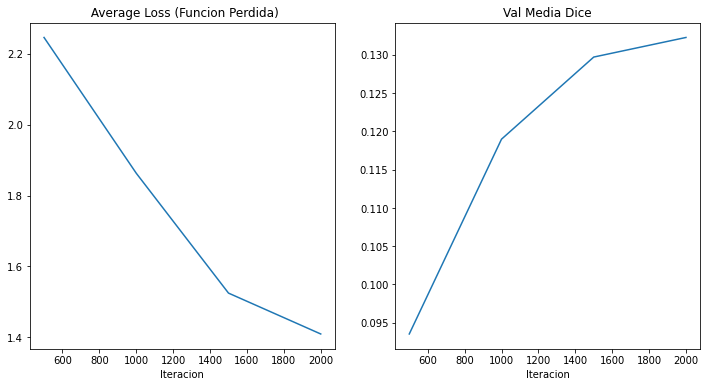

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title(" Average Loss (Funcion Perdida)")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteracion")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Media Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteracion")
plt.plot(x, y)
plt.show()

### Comprobación de la salida del mejor modelo con inferencia de una imagen y la etiqueta de entrada de una imagen de validación.

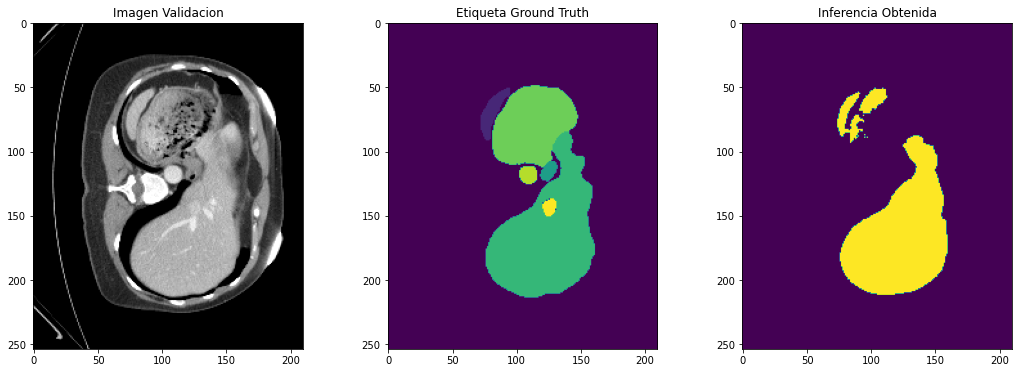

In [14]:
# Seleccionamos una imagen de validacion cualquera, por ejemplo la que esta en cuarto lugar
case_num = 4
# Cargamos el modelo que hemos entrenado y que se ha guardado al ser el de mejor métrica DICE
model.load_state_dict(torch.load(os.path.join(root_dir, "mejor_modelo_metrica.pth")))
# Lanzamos la evaluacion del modelo en PyTorch
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("Imagen Validacion")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("Etiqueta Ground Truth")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("Inferencia Obtenida")
    plt.imshow(
        torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]]
    )
    plt.show()